<h1><center>Strugatsky - Corpus and Bias analysis</center></h1>

#### 0.1 Imports:

In [1]:
import numpy as np
import pandas as pd
import subprocess
import itertools
import html2text
import requests
import shutil
import json
import os
import re

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import load_facebook_vectors
from gensim.models.word2vec import LineSentence
from gensim.models.fasttext import FastText
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from googletrans import Translator
from collections import Counter
import fasttext

import seaborn as sns; 
sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
from heatmap import heatmap, corrplot
import matplotlib.pyplot as plt


pd.set_option('display.max_rows', None)

urls = [('http://www.rusf.ru/abs/books/oo', 19, '.htm'),
        ('http://www.rusf.ru/abs/books/sot-20', 6, '.htm'),
        ('http://www.rusf.ru/abs/books/oupa', 16, '.htm'),
        ('http://www.rusf.ru/abs/books/m0', 9, '.htm'),
        ('http://www.rusf.ru/abs/books/pno0', 5, '.htm'),
        ('http://www.rusf.ru/abs/books/pip0', 8, '.htm'),
        ('http://www.rusf.ru/abs/books/zmldks', 11, '.htm'),
        ('http://www.rusf.ru/abs/books/go', 19, '.htm'),
        ('http://www.rusf.ru/abs/books/zhvm', 31,'.htm'),
        ('http://www.rusf.ru/abs/books/hs_gl', 10,'.htm'),
        ('http://www.rusf.ru/abs/books/vgv0', 7,'.htm'),
        ('http://www.rusf.ru/abs/books/oz', 29,'.htm'),
        ('http://www.rusf.ru/abs/books/zhgp0', 2,'.htm')]


mystem_to_upos = {'A':'ADJ',                                                                                                                                                                                                                                                                    
                  'ADV':'ADV',                                                                                                                                                                                                                                                                    
                  'ADVPRO':'ADV',                                                                                                                                                                                                                                                                    
                  'ANUM':'ADJ',                                                                                                                                                                                                                                                                    
                  'APRO':'DET',                                                                                                                                                                                                                                                                    
                  'COM':'ADJ',                                                                                                                                                                                                                                                                    
                  'CONJ':'SCONJ',                                                                                                                                                                                                                                                                  
                  'INTJ':'INTJ',                                                                                                                                                                                                                                                                   
                  'NONLEX':'X',                                                                                                                                                                                                                                                                     
                  'NUM':'NUM',                                                                                                                                                                                                                                                                    
                  'PART':'PART',                                                                                                                                                                                                                                                                   
                  'PR':'ADP',                                                                                                                                                                                                                                                                    
                  'S':'NOUN',                                                                                                                                                                                                                                                                   
                  'SPRO':'PRON',                                                                                                                                                                                                                                                                   
                  'UNKN':'X',                                                                                                                                                                                                                                                                     
                  'V':'VERB'}

#### 0.2 Standard paths:

In [2]:
project_dir = os.getcwd()
path_to_htmls = r'Strugatsky\html'

path_to_corpus = r'Corpus\corpus.txt'
path_to_corpus_lem = r'Corpus\corpus_lemmatized.txt'
path_to_corpus_lem_tagged = r'Corpus\corpus_lemmatized_tagged.txt'

path_to_mystem = r'Corpus\mystem.json'
path_tagged_datasets = r'Evaluation Datasets\tagged'

path_to_models = r'Models'
path_to_models_ft = os.path.join(path_to_models, 'fasttext')
path_to_models_ft_tagged = os.path.join(path_to_models_ft, 'tagged_models')

path_to_ds = r'Evaluation Datasets'
path_to_ds_tagged = r'Evaluation Datasets\tagged'

glove_tool_res_path = r'Models\GloVe\GloVe-Tool\results'
glove_dir_path = r'Models\GloVe'

ru_best_model = r'Models\fasttext\tagged_models\tayga_upos_skipgram_300_2_2019.bin'
ft_best_model = r'C:\Users\Denis Logvinenko\Desktop\Projekt\Models\fasttext\cc.ru.300.bin'
my_best_model = r'Models\fasttext\ft100_sk_lem_e20_lr.1.bin'
path_to_wls = r'Word Lists\ru'
path_to_tagged_wls = os.path.join(path_to_wls, 'tagged')
path_to_freqs = r'Corpus\freq_dict.json'

#### 0.3 Auxiliary functions:

In [3]:
def save_to_path(path, extension_of_old='.xlsx', extension_of_new='.xlsx') -> str:
    """
    Function checks if some file in path already exists and if so, it adds an
    index before the extension.
    
    Function has 2 further parameters:
        extension_of_old --> defines the extension of the original file
        extension_of_new --> defines the extension of the new file to be saved
        
    returns the new save path
    """
    
    m = re.match(f'(.+){extension_of_old}?', path)
    save_path = m.group(1) + f'{extension_of_new}'    
    j = 1
    while os.path.isfile(save_path):       
        save_path = m.group(1) + f'{j}{extension_of_new}'
        j += 1
       
    return save_path


def flatten(T):
    if not isinstance(T, tuple): return (T,)
    elif len(T) == 0: return ()
    else: return flatten(T[0]) + flatten(T[1:])
    
    
    
def download(url, filename=None):    
    
    if filename is None:
        filename = url.split('/')[-1]
            
    def check_size():
    
        if os.path.isfile(filename):
            current_size = os.stat(filename).st_size
            ratio = current_size/whole_size
            real_percentage = round(ratio*100)
            ratio_of70 = round(ratio*70)
            
            if ratio_of70 > 70 or real_percentage > 100:
                ratio_of70 = 70
                real_percentage = 100
                
            four_spaces = 4*' '
            output = f'[{ratio_of70*"#"+(70-ratio_of70)*"."}]{four_spaces}{real_percentage:>3}%'
                   
            print(f'{output:>80}', flush=True, end='\r')
            
    if os.path.isfile(filename):
        with open(filename, 'ab') as f:
            current_size = os.stat(filename).st_size
            resume_header = {'Range': 'bytes=%d-' % current_size}
            response = requests.get(url, headers=resume_header, stream=True, allow_redirects=True)

            whole_size = int(response.headers['Content-Length'])
            
            if whole_size > os.stat(filename).st_size:            
                for chunk in response.iter_content(chunk_size=512):        
                    f.write(chunk)
                    check_size()
    else:
        response = requests.get(url, stream=True, allow_redirects=True)
        whole_size = int(response.headers['Content-Length'])
        
        with open(filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=512):        
                f.write(chunk)
                check_size()
                
    if os.path.isfile(filename):        
        if whole_size > os.stat(filename).st_size:
            print('CONNECTION LOST')
            print('WHOLE SIZE =', whole_size, 'ON DISK =', os.stat(filename).st_size)
            print('RECONNECTING...')
            download(url, filename)
        
    check_size()

<h1><center>1. Obtaining and preprocessing corpus</center></h1>

#### 1.1 Functions for getting and processing the books:

In [22]:
def get_chapters(url_chapter_triples, save_dir):
    
    for url_chapter_triple in url_chapter_triples:
        prefix, number_of_chapters, extension = url_chapter_triple
        
        for chapter in range(1, number_of_chapters+1):
            
            if number_of_chapters > 9 and chapter < 10:
                chapter_url = f'{prefix}0{chapter}{extension}'
            else:
                chapter_url = f'{prefix}{chapter}{extension}'
                
            filename = f"{save_dir}/FULL_PAGE_{chapter_url.split('/')[-1]}"
            download(chapter_url, filename)


def check_chars(dir_path):
    
    chars = set()
    chars_dict = dict()
    
    for root, dirs, filenames in os.walk(dir_path):
        for filename in filenames:
            filename = os.path.join(root, filename)
            with open(filename) as f:
                html = f.read()
            text = html2text.html2text(html)
            chars_in_text = set(text)
            chars = chars.union(chars_in_text)
            
    for char in chars:
        chars_dict[char] = ord(char)
        
    chars_dict = {k: v for k, v in sorted(chars_dict.items(), key=lambda item: item[1])}
    with open('chars.txt', 'w', encoding='utf-8') as f:
        for char, code in chars_dict.items():
            f.write(f'{char}\t{code}\n')
            

def preprocess_htmls(path_to_htmls):
    
    strugatsky_sents = []
    
    for root, dirs, files in os.walk(path_to_htmls):
        for filename in files:
            filename = os.path.join(root, filename)
            if filename.endswith('.htm'):    
                with open(filename) as f:
                    html = f.read()    
                
                text = html2text.html2text(html)
            
                transl_table = str.maketrans('!?;123456789', '...000000000', 
                                             rf'"#%\'()*+,/:;=>@[\]_`|{chr(147)}{chr(148)}§«º»№')
                text = text.translate(transl_table)    
                
                text = text.split('\n')
                text_splitted = [line for line in text if line.strip()]
                
                bad_sents = ['htm', 'jpg', 'http', 'design', 'ru']
                
                if 'FULL_PAGE_' in filename:
                    if filename.endswith('01.htm'):
                        text_splitted = text_splitted[35:-12]
                    else:
                        text_splitted = text_splitted[35:-13]
                        
                text_splitted = [line for line in text_splitted if 
                                 all(term not in line for term in bad_sents)]
                    
                    
                text_clean = ' '.join(text_splitted)
                text_clean_sents = text_clean.split('.')
                
                text_clean_sents1 = []
                for sent in text_clean_sents:
                    sent = sent.lower().replace('- ', '').strip()
                    if len(sent) > 1:
                        text_clean_sents1.append(sent)
                        
                del text_clean_sents
                strugatsky_sents.extend(text_clean_sents1)
                
    with open('strugatsky_preprocesed.txt', 'w') as f:
        for sent in strugatsky_sents:
            f.write(f'{sent}\n')


def show_spaced_words(path_to_corpus):
    
    pattern = '(.*? )??(([^ ]\s){4,}).*'
    regex = re.compile(pattern) 

    with open(path_to_corpus, encoding='utf-8') as f:
        lines = f.readlines()

    matched_lines = [regex.match(line).group(2) for line in lines if regex.match(line) is not None]
    matched_ser = pd.Series(matched_lines)

    print(matched_ser.drop_duplicates().sort_values())


def delete_one_letter_words(path_to_corpus):
    # [^аиовуксяж0 ] #
    good_words = ['а', 'и', 'у', 'о', 'в', 'к', 'с', 'я', '0']
    
    with open(path_to_corpus, encoding='utf-8') as f:
        sents = f.readlines()
        
    sents = [sent.split() for sent in sents]
    new_filter = lambda x: len(x)>1 or x in good_words    
    filtered = [filter(new_filter, sent) for sent in sents]
    
    filtered_save_path = re.match(f'(.+)\..+', path_to_corpus).group(1) + '_filtered.txt'
    
    with open(filtered_save_path, 'w', encoding='utf-8') as f:
        for line in filtered:
            line_str = ' '.join(line)
            if line_str:
                f.write(f'{line_str}\n')
            

#### 1.2 Getting and creating first versions of the corpus:

In [ ]:
get_chapters(url_chapter_triples=urls, save_dir=path_to_htmls)
    
check_chars(path_to_htmls)

preprocess_htmls(path_to_htmls)

show_spaced_words(path_to_corpus)
# AFTER THIS FUNCTION MANUAL DELETION OF SPACED WORDS IN THE RESULTING CORPUS IS REQUIRED

delete_one_letter_words(path_to_corpus)
# IT IS IMPERATIVE TO RESAVE THE FILE IN UTF-8 (EVEN IF WE ALREADY DID THAT WITH open(...encoding='utf-8'))
# OTHERWISE THERE WILL BE PROBLEMS WHILE OPENING TRAINED MODELL

<h1><center>2. Lemmatization</center></h1>

#### 2.1 Use Yandex <a href="https://yandex.ru/dev/mystem/">mystem</a> to lemmatize corpus: 

In [17]:
# Mystem is a console application for lemmatization from Yandex, which can be downloaded here:
# https://yandex.ru/dev/mystem/

os.chdir(r'Corpus')

path_to_corpus = 'corpus.txt'
path_to_mystem = 'mystem.json'
command = rf'mystem -gi --format json {path_to_corpus} {path_to_mystem}'
subprocess.run(command, check=True)

os.chdir(project_dir)

#### 2.2 Extracting necessary info from json:

In [18]:
def create_lem_corpus(path_to_mystem=path_to_mystem, pos=False): 
    
    f = open(path_to_mystem, encoding='utf-8')
    corpus_lem = []    
        
    for line in f:
            sent_analysis = json.loads(line)            
            sent = []
            for word in sent_analysis:
                if 'analysis' in word and word['analysis']:
                    lemma = word['analysis'][0]['lex']
                    if pos:
                        tags = word['analysis'][0]['gr']            
                        tag = tags.split(',')[0].split('=')[0]
                        tag = mystem_to_upos[tag]
                        tagged_word = f'{lemma}_{tag}'
                        sent.append(tagged_word)
                        continue
                    sent.append(lemma)
                else:
                    sent.append(word['text'])
                    
            corpus_lem.append(" ".join(sent) + '\n')

    f.close()
    
    if pos:                        
        save_path = 'corpus_lemmatized_tagged.txt'
    else:
        save_path = 'corpus_lemmatized.txt'
                             
    with open(save_path, 'w', encoding='utf-8') as f:
        for sent in corpus_lem:
            f.write(sent)

create_lem_corpus(pos=False)
create_lem_corpus(pos=True)

#### 2.3 Showing words with count = N:

In [5]:
### Here we can see examples of words that occur N (>=2 in this example) times in the corpus
### Also interesting can be the number of words in each frequency-category

def show_words(path, wcount=2, save_freq_dict=False):
    with open(path, encoding='utf-8') as f:
        least_common = Counter(f.read().split()).most_common()[::-1]
    
    freqs_dict = dict(least_common)
    if save_freq_dict:
        save_path = os.path.join(os.path.dirname(path), 'freq_dict.json')
        with open(save_path, 'w', encoding='utf-8') as f:
            json.dump(freqs_dict, f)
            
    words_dict = [ (word, count) for word, count in freqs_dict.items() if count >= wcount ][:100]

    freqs = Counter([str(count)+' time(s) in text' for word, count in least_common]).most_common(100)

    print(words_dict)
    print(freqs)

show_words(path_to_corpus)    
show_words(path_to_corpus_lem, save_freq_dict=True)
show_words(path_to_corpus_lem_tagged)

<h1><center>3. Training and evaluating vectors</center></h1>

### 3.0 Some preprocessing on datasets:

#### 3.0.1 Extracting info from mystem json to get tagged datasets:

In [19]:
def tagged_ds_tocsv(path_tagged_datasets=path_tagged_datasets):
    
    tagged_dir = os.listdir(path_tagged_datasets)
    tagged_datasets = [dataset_name for dataset_name in tagged_dir if dataset_name.endswith('.json')]

    for dataset_name in tagged_datasets:
        
        ds_fullpath = os.path.join(path_tagged_datasets, dataset_name) 
        f = open(ds_fullpath, encoding='utf-8')
        tagged_ds = []    

        for line in f:
            sent_analysis = json.loads(line)            
            sent = []
            for word in sent_analysis:
                if 'analysis' in word and word['analysis']:
                    lemma = word['analysis'][0]['lex']
                    tags = word['analysis'][0]['gr']            
                    tag = tags.split(',')[0].split('=')[0]
                    tag = mystem_to_upos[tag]
                    tagged_word = f'{lemma}_{tag}'
                    sent.append(tagged_word)
                else:
                    sent.append(word['text'])

            tagged_ds.append(''.join(sent))

        f.close()
        
        save_path = save_to_path(ds_fullpath, extension_of_old='.json', extension_of_new='.csv')
        with open(save_path, 'w', encoding='utf-8') as f:
            for sent in tagged_ds:
                f.write(sent)

tagged_ds_tocsv()

#### 3.0.2 Convert already tagged datasets to UPOS:

In [35]:
tagged_dir = os.listdir(path_tagged_datasets)
tagged_datasets = [dataset_name for dataset_name in tagged_dir if dataset_name.endswith('.csv')]
pattern = re.compile('_(.+)')
i = 0
for ds in tagged_datasets:
    ds_fullpath = os.path.join(path_tagged_datasets, ds)
    new_tagged = []
    
    with open(ds_fullpath, encoding='utf-8') as f:
        content = [line.split(',') for line in f if line]
    
    for line in content:
        matched1 = pattern.search(line[0]).group(1)
        replace1 = mystem_to_upos[matched1]
        try:
            matched2 = pattern.search(line[1]).group(1)
        except AttributeError:
            print(line)
            print(ds)
        replace2 = mystem_to_upos[matched2]
        word1_new = line[0].replace(matched1, replace1)
        word2_new = line[1].replace(matched2, replace2)
        sim = line[2]
        new_tagged.append((word1_new, word2_new, sim))
    
    save_path = save_to_path(ds_fullpath, extension_of_old='.csv', extension_of_new='.csv')
    with open(save_path, 'w', encoding='utf-8') as f:
        for word1, word2, sim in new_tagged:
            f.write(f'{word1},{word2},{sim}')
    


['фонд_S', 'cd', '0.000000\n']
hj_tagged.csv
['фонд_S', 'cd', '0.000000\n']
hj_wordsim353_relatedness_tagged.csv
['фонд_S', 'cd', '0.000000\n']
hj_wordsim353_similarity_tagged.csv


['фонд_S', 'cd', '0.000000\n'] <br>
hj_tagged.csv <br>
['фонд_S', 'cd', '0.000000\n'] <br>
hj_wordsim353_relatedness_tagged.csv <br>
['фонд_S', 'cd', '0.000000\n'] <br>
hj_wordsim353_similarity_tagged.csv

### 3.1 Function to evaluate models:

In [4]:
def evaluate(path_to_models=path_to_models, path_to_ds=path_to_ds, show_oov=True):
    eval_sets = []
    models = []
    evaluation_results = []  
    average_oov = []
    
    models_dir = os.listdir(path_to_models)
    models = [model_name for model_name in models_dir if model_name.endswith('.bin')]
    
    eval_dir = os.listdir(path_to_ds)
    eval_sets = [eval_set_name for eval_set_name in eval_dir if eval_set_name.endswith('.csv')]  

    for model_name in models:
        model = KeyedVectors.load_word2vec_format(os.path.join(path_to_models, model_name), binary=True)
        evaluated = []
        oov = []

        for eval_set_name in eval_sets:
            path_eval = os.path.join(path_to_ds, eval_set_name)
            try:
                evaluation =  flatten(model.evaluate_word_pairs(path_eval, delimiter=','))
            except ValueError:
                print(eval_set_name)
                print(model_name)
            spearman = evaluation[2]
            oov_value = evaluation[-1]
            
            oov.append(oov_value)
            evaluated.append(spearman)
            
        evaluation_results.append(evaluated)
        average_oov.append(np.mean(oov))
        del model

    eval_df = pd.DataFrame(data=evaluation_results, index=models, columns=eval_sets)
        
    eval_df['Average'] = eval_df.mean(numeric_only=True, axis=1)
    if show_oov:
        eval_df['oov'] = average_oov
    
    eval_df.sort_values(by='Average', ascending=False, inplace=True)   
    
    save_path_excel = os.path.join(path_to_models, 'evaluation.xlsx')
    save_path_excel = save_to_path(save_path_excel)
    
    eval_df.to_excel(save_path_excel, sheet_name='Evaluation', header=True, index=True, 
                     merge_cells=True, float_format="%.2f")

### 3.2 FastText:

#### 3.2.1 Function to train fasttext:

In [11]:
def train_ft(path_to_corpus=path_to_corpus_lem, model='skipgram', dim=100, epoch=10, 
             lr=0.1, minn=3, maxn=6, save_dir=path_to_models_ft):
    
    prefix_model = 'sk' if model == 'skipgram' else 'cb'
    prefix_lem = 'lem' if 'lem' in path_to_corpus else ''
    prefix_tagged = 'pos' if 'tagged' in path_to_corpus else ''
    prefix_epoch = 'e' + str(epoch)
    prefix_lr = 'lr' + str(lr)[1:]
    prefix_minn_maxn = ''
    if minn != 3 or maxn != 6:
        prefix_minn_maxn = str(minn) + '_' + str(maxn)
    
    prefixes = ['ft'+str(dim), prefix_model, prefix_lem, prefix_tagged, prefix_epoch, prefix_lr, prefix_minn_maxn]
    prefixes = [prefix for prefix in prefixes if prefix]
    prefixes = '_'.join(prefixes)
    print(f'Model "{prefixes}" is training!')

    model_trained = fasttext.train_unsupervised(input=path_to_corpus, minCount=2, thread=4, 
                                                model=model, dim=dim, epoch=epoch, lr=lr, 
                                                minn=minn, maxn=maxn)
    if prefix_tagged:
        save_dir = os.path.join(save_dir, 'tagged_models')

    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
        
    save_path = save_dir + os.sep + prefixes
    model_trained.save_model(save_path)

    print(f'Training of "{prefixes}" is complete!')
    del model_trained

    model_trained = load_facebook_vectors(save_path, encoding='utf-8')

    print(f'Saving "{prefixes}" in gensim binary format!\n')
    save_path_new = save_path + '.bin'
    model_trained.save_word2vec_format(save_path_new, binary=True)
    os.remove(save_path)
    del model_trained
                

#### 3.2.2 Parameters for training and evaluation of fasttext models:

In [12]:
### lr=0.3 is too high!
### RuntimeError is thrown:
### https://fasttext.cc/docs/en/faqs.html#i-m-encountering-a-nan-why-could-this-be

# path_to_corpus, model='skipgram', dim=100, epoch=10, lr=0.1, minn=3, maxn=6

parameters_dict = { 'path_to_corpus' : [path_to_corpus, path_to_corpus_lem, path_to_corpus_lem_tagged],
                    'model' : ['skipgram', 'cbow'],
                    'epoch' : [10, 20],
                    'dim' : [100, 200],
                    'lr' : [0.05, 0.1] }

parameters_dict = { 'path_to_corpus' : [path_to_corpus_lem_tagged],
                    'model' : ['skipgram', 'cbow'],
                    'epoch' : [10, 20],
                    'dim' : [100, 200],
                    'lr' : [0.05, 0.1] }

permutations = itertools.product(*parameters_dict.values())
parameters_list = [dict(zip(parameters_dict, v)) for v in permutations]

for params in parameters_list:
    train_ft(**params)

Model "ft100_sk_lem_pos_e10_lr.05" is training!
Training of "ft100_sk_lem_pos_e10_lr.05" is complete!
Saving "ft100_sk_lem_pos_e10_lr.05" in gensim binary format!

Model "ft100_sk_lem_pos_e10_lr.1" is training!
Training of "ft100_sk_lem_pos_e10_lr.1" is complete!
Saving "ft100_sk_lem_pos_e10_lr.1" in gensim binary format!

Model "ft200_sk_lem_pos_e10_lr.05" is training!
Training of "ft200_sk_lem_pos_e10_lr.05" is complete!
Saving "ft200_sk_lem_pos_e10_lr.05" in gensim binary format!

Model "ft200_sk_lem_pos_e10_lr.1" is training!
Training of "ft200_sk_lem_pos_e10_lr.1" is complete!
Saving "ft200_sk_lem_pos_e10_lr.1" in gensim binary format!

Model "ft100_sk_lem_pos_e20_lr.05" is training!
Training of "ft100_sk_lem_pos_e20_lr.05" is complete!
Saving "ft100_sk_lem_pos_e20_lr.05" in gensim binary format!

Model "ft100_sk_lem_pos_e20_lr.1" is training!
Training of "ft100_sk_lem_pos_e20_lr.1" is complete!
Saving "ft100_sk_lem_pos_e20_lr.1" in gensim binary format!

Model "ft200_sk_lem_pos_e

#### 3.2.3 Evaluation:

In [17]:
evaluate(path_to_models=path_to_models_ft, path_to_ds=path_to_ds)
evaluate(path_to_models=path_to_models_ft_tagged, path_to_ds=path_to_ds_tagged)

### 3.3 GloVe - trained with Stanford-Tool:

#### 3.3.1 Script to run GloVe-Tool:

In [ ]:
script = 
"""
#!/bin/bash
make .

CORPUS=corpus_lemmatized.txt
VOCAB_FILE=results/vocab.txt
COOCCURRENCE_FILE=results/cooccurrence.bin
COOCCURRENCE_SHUF_FILE=results/cooccurrence.shuf.bin
BUILDDIR=build

VERBOSE=2
MEMORY=8.0
VOCAB_MIN_COUNT=2
BINARY=2
NUM_THREADS=8
X_MAX=10

for VECTOR_SIZE in 50 100 300
    do 
    for MAX_ITER in 20 30
        do
        for WINDOW_SIZE in 10 15 20
            do

        SAVE_FILE="results/glove_${VECTOR_SIZE}d_${MAX_ITER}it_${WINDOW_SIZE}win"

        $BUILDDIR/vocab_count -min-count $VOCAB_MIN_COUNT -verbose $VERBOSE < $CORPUS > $VOCAB_FILE
        if [[ $? -eq 0 ]]
          then
          $BUILDDIR/cooccur -memory $MEMORY -vocab-file $VOCAB_FILE -verbose $VERBOSE -window-size $WINDOW_SIZE < $CORPUS > $COOCCURRENCE_FILE
          if [[ $? -eq 0 ]]
          then
            $BUILDDIR/shuffle -memory $MEMORY -verbose $VERBOSE < $COOCCURRENCE_FILE > $COOCCURRENCE_SHUF_FILE
            if [[ $? -eq 0 ]]
            then
               $BUILDDIR/glove -save-file $SAVE_FILE -threads $NUM_THREADS -input-file $COOCCURRENCE_SHUF_FILE -x-max $X_MAX -iter $MAX_ITER -vector-size $VECTOR_SIZE -binary $BINARY -vocab-file $VOCAB_FILE -verbose $VERBOSE
            fi
          fi
        fi
        done
    done
done

"""

#### 3.3.2 Convert GloVe-Vectors to Word2Vec-format:
(The difference is that in GloVe-format one does not have a header: "words_count    dims")

In [8]:
glove_dir = os.listdir(glove_tool_res_path)
models = [model_name.split('.')[0] for model_name in glove_dir if 'glove_' in model_name and model_name.endswith('.txt')]

for model_name in models:                       
    glove_file = os.path.join(glove_tool_res_path, model_name + '.txt')
    glove_w2v_format = os.path.join(glove_dir_path, model_name + '.bin')

    _ = glove2word2vec(glove_file, glove_w2v_format)

    model = KeyedVectors.load_word2vec_format(glove_w2v_format)
    model.save_word2vec_format(glove_w2v_format, binary=True)
    del model

#### 3.3.3 Evaluation:

In [5]:
evaluate(path_to_models=glove_dir_path)

<h1><center>4. Measuring Bias</center></h1>

### 4.0 Find most common names in corpus:

In [16]:
# {"lex":"катаев","gr":"S,фам,муж,од=им,ед"}
# {"lex":"дональд","gr":"S,имя,муж,од=им,ед"}

def find_most_common_names(path_to_mystem=path_to_mystem): 
    
    f = open(path_to_lem_corpus, encoding='utf-8')
    male_names = []
    female_names = []
        
    for line in f:
            sent_analysis = json.loads(line)            
            for word in sent_analysis:
                if 'analysis' in word and word['analysis']:                    
                    lemma = word['analysis'][0]['lex']
                    tags = word['analysis'][0]['gr']            
                    if 'имя' in tags or 'фам' in tags:
                        if 'муж' in tags:
                            male_names.append(lemma)
                        elif 'жен' in tags:
                            female_names.append(lemma)
                        
    f.close()
    
    male_names_counter = Counter(male_names).most_common()
    female_names_counter = Counter(female_names).most_common()
    names_ranking = zip(male_names_counter, female_names_counter)
    
    save_path = os.path.join(os.path.dirname(path_to_mystem), 'names_ranking.txt')
                             
    with open(save_path, 'w', encoding='utf-8') as f:
        for male, female in names_ranking:
            male_string = f'{male[0]:<15} {male[1]}'
            female_string = f'{female[0]:<15} {female[1]}'
            f.write(f'{male_string:<20} {female_string}\n')
            
#find_most_common_names()

### 4.1 Creating word lists (based on Garg et al. (2018)):

#### 4.1.1 Check word in model:

In [18]:
best_model = my_best_model

model = KeyedVectors.load_word2vec_format(best_model, binary=True)

In [19]:
word = 'обманывать'
word_in_model = word in model
print(word_in_model)
if word_in_model:        
    print(model.most_similar(word))
    print(model.similarity(word, 'мужчина'))
    print(model.similarity(word, 'женщина'))

True
[('унывать', 0.6490638852119446), ('обман', 0.642913281917572), ('привходящий', 0.5784028768539429), ('издеваться', 0.5353907942771912), ('кэпэдэ', 0.5144190192222595), ('дразнить', 0.508590579032898), ('обмолвиться', 0.5058943629264832), ('халиф', 0.5002902746200562), ('девать', 0.4919360280036926), ('долдонить', 0.4898584187030792)]
0.23483701
0.2898078


#### 4.1.2 Translate Lists from Garg's Paper:

In [53]:
def translate_garg(path_to_en, save_dir):
    translator = Translator()
    
    if os.path.isfile(path_to_en):
        word_lists = [path_to_en.split(os.sep)[-1]]
        path_to_en = os.path.dirname(path_to_en)       
 
    else:
        word_lists = os.listdir(path_to_en)
        word_lists = [word_list for word_list in word_lists if word_list.endswith('.txt')]
    
    for word_list in word_lists:
        path_to_list = os.path.join(path_to_en, word_list)
        
        with open(path_to_list) as f:
            words = [line.strip() for line in f if line]            
        """    
        try:
            translations = translator.translate(words, dest='ru')
            
        except json.decoder.JSONDecodeError:
        """        
        translations = []
        for idx, word in enumerate(words):
            if idx%10 == 0:
                translator = Translator()
            translations.append(translator.translate(word, dest='ru'))
        
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
            
        save_path = os.path.join(save_dir, word_list)
        save_path = save_to_path(save_path, extension_of_old='.txt', extension_of_new='_en-ru.txt')
        with open(save_path, 'w') as f:
            for translation in translations:
                f.write(f'{translation.origin}\t{translation.text}\n')
        
path_to_en = r'Word Lists\en'
save_dir = r'Word Lists\ru'
translate_garg(path_to_en, save_dir)

### Following word list is too large to translate with googletrans
### It therefore needs to be translated manually using the website 

path_to_traits = r'Word Lists\en\personalitytraits_original.txt'
path_to_traits_ru = r'Word Lists\ru\personalitytraits_original_en-ru.txt'

with open(path_to_traits) as f:
    words_en = [line.strip() for line in f if line]

with open(path_to_traits_ru) as f:
    words_ru = [line.strip() for line in f if line]

en_ru = zip(words_en, words_ru)

with open(path_to_ru, 'w') as f:
    for en, ru in en_ru:
        f.write(f'{en}\t{ru}\n')

#### 4.1.3 Delete duplicates from translations:

In [696]:
def delete_same_words(path_to_list):
    
    with open(path_to_list) as f:
        words_en_ru = {}
        for line in f:
            if line:
                word_en = line.split()[0]
                word_ru = line.split()[1]
                if word_ru not in words_en_ru:
                    words_en_ru[word_ru] = word_en
                    
    save_path = save_to_path(path_to_list, extension_of_old='.txt', extension_of_new='.txt')
    with open(save_path, 'w') as f:
        for word_ru, word_en in words_en_ru.items():
            f.write(f'{word_en}\t{word_ru}\n')
            
path_to_list = r'Word Lists\ru\personalitytraits_original_en-ru.txt'
delete_same_words(path_to_list)

#### 4.1.4 Prepare word lists to be used with one of the best models from <a href="http://rusvectores.org/models">RusVectores</a>:

In [ ]:
### Here we create lemmatized neutral word lists that can be used to measure bias in
### the UPOS-tagged models from rusvectores

def create_tagged_wls(path_to_word_lists=path_to_word_lists, conversion_table=mystem_to_upos, 
                      save_dir=path_to_tagged_wls):
    
    dir_at_begin = os.getcwd()
    wl_dir = os.listdir(path_to_word_lists)
    wls = [wl_name for wl_name in wl_dir if 'FINAL' in wl_name]
    paths_to_wls_tagged = []
    
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
        
    os.chdir(path_to_word_lists)
    for wl_name in wls:
        path_to_wl_tagged = save_to_path(wl_name, extension_of_old='.txt', extension_of_new='_tagged.json')
        command = rf'mystem -gi --format json {wl_name} {save_dir.split(os.sep)[-1]}\{path_to_wl_tagged}'
        subprocess.run(command, check=True)
        
        full_path_to_wl_tagged = os.path.join(save_dir, path_to_wl_tagged)
        paths_to_wls_tagged.append(full_path_to_wl_tagged)
        
    for wl_fullpath in paths_to_wls_tagged:
 
        f = open(wl_fullpath, encoding='utf-8')
        tagged_wl = []    

        for line in f:
            sent_analysis = json.loads(line)            
            en_word = sent_analysis[0]['text']
            ru_word = sent_analysis[1]
            
            ru_tags = ru_word['analysis'][0]['gr']            
            ru_tag = ru_tags.split(',')[0].split('=')[0]
            ru_tag = conversion_table[ru_tag]
            tagged_ru_word = f'{ru_word["text"]}_{ru_tag}'

            tagged_wl.append(f'{en_word}\t{tagged_ru_word}\n')

        f.close()
        
        save_path_tagged_txt = save_to_path(wl_fullpath, extension_of_old='.json', extension_of_new='.txt')
        with open(save_path_tagged_txt, 'w', encoding='utf-8') as f:
            for sent in tagged_wl:
                f.write(sent)                
    os.chdir(dir_at_begin)
        
create_tagged_wls()

#### 4.1.5 Check for OOV-words in tagged datasets:
(caused mainly by the incosistency of tagging, such as the lack of present participles in the "taiga"-modell)

In [25]:
def check_oov_in_tagged(path_to_model=ru_best_model,
                        path_to_tagged_wls=path_to_tagged_wls):

    wl_dir = os.listdir(path_to_tagged_wls)
    wls = [wl_name.split('.')[0] for wl_name in wl_dir if wl_name.endswith('.txt')]
    
    model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
    oov = []
    
    for wl_name in wls:
        wl_path = os.path.join(path_to_tagged_wls, wl_name+'.txt')
        
        with open(wl_path, encoding='utf-8') as f:
            words_ru = [line.split()[1] for line in f if line]
        
        for idx, word in enumerate(words_ru, start=1):
            if word not in model:
                oov.append((wl_name, idx, word))
    save_path = os.path.join(path_to_tagged_wls, 'oov.txt')            
    with open(save_path, 'w', encoding='utf-8') as f:
        for wl_name, idx, word in oov:
            f.write(f'{wl_name},{idx},{word}\n')
    
check_oov_in_tagged()

### 4.2 Measuring bias in word lists:

#### 4.2.1 Parameters for measuring:

In [4]:
top10_male_names = ['быков', 'иван', 'панин', 'валькенштейн', 'отто',
                    'тэдди', 'кирилл', 'леонид', 'воронин', 'гальцев']

top10_female_names = ['диана', 'сельма', 'наташа', 'зоя', 'шейла',
                      'ирок', 'ирма', 'анка', 'таня', 'мария']

male_words = ['сын', 'отец', 'мужчина', 'мальчик', 'мужской', 'брат', 
              'дядя', 'племянник', 'парень', 'господин', 'он']

female_words = ['дочь', 'мама', 'женщина', 'девочка', 'женский', 'сестра', 
                'тетя', 'племянница', 'девушка', 'госпожа', 'она']

male_words_tagged = ['сын_NOUN', 'отец_NOUN', 'мужчина_NOUN', 'мальчик_NOUN', 'мужской_ADJ', 'брат_NOUN', 
                     'дядя_NOUN', 'племянник_NOUN', 'парень_NOUN', 'господин_NOUN']

female_words_tagged = ['дочь_NOUN', 'мама_NOUN', 'женщина_NOUN', 'девочка_NOUN', 'женский_ADJ', 'сестра_NOUN', 
                       'тетя_NOUN', 'племянница_NOUN', 'девушка_NOUN', 'госпожа_NOUN']

#### 4.2.2 Auxiliary functions:

In [5]:
def get_freqs(path_to_freqs=path_to_freqs):
    with open(path_to_freqs) as f:
        freq_dict = json.load(f)
    return freq_dict


def group_vector(model, group_words):
    return (1/len(group_words))*np.sum([model.get_vector(word) for word in group_words], axis=0)


def cos(v1, v2): 
    return np.dot(v1, v2)/np.linalg.norm(v1)/np.linalg.norm(v2)

                           
def relative_norm_bias(model, group_vector1, group_vector2, neutral_words):
    biases = []
    norm_dif = lambda x, y: np.linalg.norm(np.subtract(x, y))
    for neutral_word in neutral_words:
        neutral_word_vec = model.get_vector(neutral_word)
        bias = np.subtract(norm_dif(neutral_word_vec, group_vector1), norm_dif(neutral_word_vec, group_vector2))
        biases.append(bias)
    return biases


def cos_bias(model, group_vector1, group_vector2, neutral_words):
    biases = []
    for neutral_word in neutral_words:
        neutral_word_vec = model.get_vector(neutral_word)
        bias = np.subtract(cos(neutral_word_vec, group_vector2), cos(neutral_word_vec, group_vector1))
        biases.append(bias)
    return biases

#### 4.2.3 Function to compute bias and create a table with the results:

In [6]:
def rank_association(male_words, female_words, path_to_word_lists=path_to_wls,
                     path_to_model=my_best_model, save_as_dict=True):
    
    model = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
    #freq_dict = get_freqs()
    
    male_vector = group_vector(model, male_words)
    female_vector = group_vector(model, female_words)
    
    wl_dir = os.listdir(path_to_word_lists)
    wls = [wl_name.split('.')[0] for wl_name in wl_dir if wl_name.endswith('.txt')]
    biases_measured_in_wls = []
    dfs = []
    bias_dict = {}
    
    # y_labels_second = ['word_RU', 'word_count', 'word_EN', 'bias_score']
    y_labels_second = ['word_RU', 'word_EN', 'bias_score']
    
    for wl_name in wls:
        wl_path = os.path.join(path_to_word_lists, wl_name+'.txt')
        
        with open(wl_path, encoding='utf-8') as f:
            words_en_ru = [line.split() for line in f if line]
        
        words_en = [words[0] for words in words_en_ru]
        words_ru = [words[1] for words in words_en_ru]            
        #neutral_w_count = [freq_dict[neutral_word] for neutral_word in words_ru]
        
        bias_in_wl = cos_bias(model, male_vector, female_vector, words_ru)
        #result = np.asarray(list(zip(words_ru, neutral_w_count, words_en, bias_in_wl)))
        result = np.asarray(list(zip(words_ru, words_en, bias_in_wl)))
        biases_measured_in_wls.append(result)
        
        if save_as_dict:
            bias_dict[wl_name] = [[x, y.item()] for x, y in sorted(zip(words_ru, bias_in_wl))]
        
        y_labels = [(wl_name, y_sec) for y_sec in y_labels_second]
        mult_idx = pd.MultiIndex.from_tuples(y_labels)
        df = pd.DataFrame(data=result, columns=mult_idx)
        df[(wl_name, 'bias_score')] = pd.to_numeric(df[(wl_name, 'bias_score')])
        #df[(wl_name, 'word_count')] = pd.to_numeric(df[(wl_name, 'word_count')])
        df.sort_values(by=[(wl_name, 'bias_score')], ascending=False, inplace=True, ignore_index=True)
        #print(df.head(10))
        dfs.append(df)
    
    dfs.sort(key=lambda x: -x.shape[0])
    assoc_rank_df = pd.concat(dfs, axis=1)
    
    save_path_excel = os.path.join(path_to_word_lists, 'association.xlsx')
    save_path_excel = save_to_path(save_path_excel)
    
    assoc_rank_df.to_excel(save_path_excel, sheet_name='association', header=True, 
                           index=True, merge_cells=True, float_format="%.3f")

    if save_as_dict:
        bias_dict_sorted = {k:bias_dict[k] for k in sorted(bias_dict, key=lambda k: -len(bias_dict[k]))}
        save_path_json = save_to_path(save_path_excel, extension_of_old='.xlsx', extension_of_new='.json') 
        with open(save_path_json, 'w', encoding='utf-8') as f:
            json.dump(bias_dict_sorted, f)


#### 4.2.4 Bias-Tests on Strugatsky-Modell with different definitions for gender-vectors:

In [21]:
# TEST 1:
rank_association(male_words, female_words, path_to_word_lists=path_to_wls, 
                 path_to_model=my_best_model, save_as_dict=True)

# TEST 2:
male_words_new = male_words + top10_male_names
female_words_new = female_words + top10_female_names
rank_association(male_words_new, female_words_new, path_to_word_lists=path_to_wls, 
                 path_to_model=my_best_model, save_as_dict=True)

# TEST 3:
rank_association(top10_male_names, top10_female_names, path_to_word_lists=path_to_wls, 
                 path_to_model=my_best_model, save_as_dict=True)

#### 4.2.5 Bias-Test with the fastText-Model:

In [69]:
rank_association(male_words, female_words, 
                 path_to_word_lists=path_to_wls, 
                 path_to_model=ft_best_model)

#### 4.2.6 Bias-Test with the Taiga-Model:

In [14]:
rank_association(male_words_tagged, female_words_tagged, 
                 path_to_word_lists=path_to_tagged_wls, 
                 path_to_model=ru_best_model)

### 4.3 Correlation Heatmaps for the Tests:

#### 4.3.1 Functions to create Heatmaps and save them as vector graphics:

In [15]:
def update_df(df):
    allowed = [0, 4, 8]
    rows = df.shape[0]
    cols = df.shape[1]
    for i in range(rows):
        for j in range(cols):
            if j not in allowed:
                df.iat[i, j] = 0
        allowed = update_idx(allowed)
    return df


def update_idx(indices, upd=1, max_val=11):
    updated = []
    for i in indices:
        diff = i+upd-max_val
        if diff > 0:
            j = diff-1
        else:
            j = i+upd
        updated.append(j)
    updated.sort()
    return updated


def heatmap_markers(path_to_jsons, data_labels=None, full=True, marker='*'):
    data_extracted = []
    jsons_dir = os.listdir(path_to_jsons)
    json_files = [file for file in jsons_dir if file.endswith('.json') and 'association' in file]
    for json_f in json_files:
        full_path = os.path.join(path_to_jsons, json_f)
        with open(full_path, encoding='utf-8') as f:
            extracted = json.load(f)
        data_extracted.append(extracted)
        
    if not full:
        data_extracted = [{i:[value for values in res_dict.values() for value in values]}
                          for i, res_dict in enumerate(data_extracted)]
    
    num_tests = len(data_extracted)
    num_wls = len(data_extracted[0])
   
    if data_labels is None:
        data_labels = [f'T{x+1}WL{y+1}' if full else f'T{x+1}' for x in range(num_tests) for y in range(num_wls)]
    
    dfs = [pd.DataFrame(data=[result[1] for result in wl_results]) 
           for res_dict in data_extracted for wl_results in res_dict.values()]
    data_df = pd.concat(dfs, axis=1)
    data_df.columns = data_labels
    
    if not full:
        corr_matrix = data_df.corr()
    else:
        corr_matrix = update_df(data_df.corr())

    corr_matrix = pd.melt(corr_matrix.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
    corr_matrix.columns = ['x', 'y', 'value']
    
    if not full:
        plt.figure(figsize=(5,4))
    else:
        plt.figure(figsize=(9,7))
        
    heatmap(x=corr_matrix['x'],y=corr_matrix['y'], size_scale=200,
            marker=marker, size=corr_matrix['value'].abs(),
            palette=sns.color_palette("RdBu_r", 7))    

    save_path = save_to_path(os.path.join(path_to_wls, 'heatmap.svg'), 
                             extension_of_old='.svg', extension_of_new='.svg')
    plt.savefig(save_path, facecolor='w', format='svg')

    
def heatmap_classic(path_to_jsons, data_labels=None, vmin=0, full=True):
    
    data_extracted = []
    
    jsons_dir = os.listdir(path_to_jsons)
    json_files = [file for file in jsons_dir if file.endswith('.json') and 'association' in file]
    for json_f in json_files:
        full_path = os.path.join(path_to_jsons, json_f)
        with open(full_path, encoding='utf-8') as f:
            extracted = json.load(f)
        data_extracted.append(extracted)
        
    if not full:
        data_extracted = [{i:[value for values in res_dict.values() for value in values]}
                          for i, res_dict in enumerate(data_extracted)]
    
    num_tests = len(data_extracted)
    num_wls = len(data_extracted[0])
    
    if data_labels is None:
        data_labels = [f'T{x+1}WL{y+1}' if full else f'T{x+1}' for x in range(num_tests) for y in range(num_wls)]
    
    dfs = [pd.DataFrame(data=[result[1] for result in wl_results]) 
           for res_dict in data_extracted for wl_results in res_dict.values()]
    data_df = pd.concat(dfs, axis=1)
    data_df.columns = data_labels

    if not full:
        corr_matrix = data_df.corr()
    else:
        corr_matrix = update_df(data_df.corr())

    if full:
        plt.figure(figsize=(9,7))
    else:        
        plt.figure(figsize=(5,4))
 
    ax = sns.heatmap(corr_matrix, xticklabels=corr_matrix.columns, vmin=vmin,
                     yticklabels=corr_matrix.columns, annot=True, square=True)
    ax.invert_yaxis()
    if full:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    save_path = save_to_path(os.path.join(path_to_jsons, 'heatmap.svg'), 
                             extension_of_old='.svg', extension_of_new='.svg')
    plt.savefig(save_path, facecolor='w', format='svg')


#### 4.3.2 Measuring correlation for tests with Strugatsky-Modell:

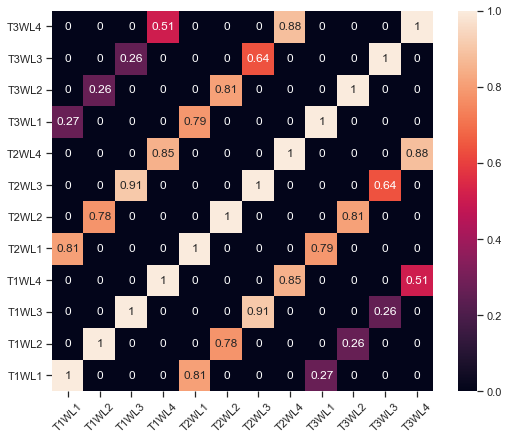

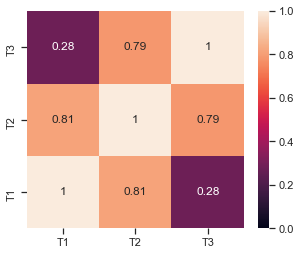

In [64]:
heatmap_classic(path_to_jsons=path_to_wls, full=True)
heatmap_classic(path_to_jsons=path_to_wls, full=False)

#### 4.3.3 Measuring correlation between 3 models for the Russian language:

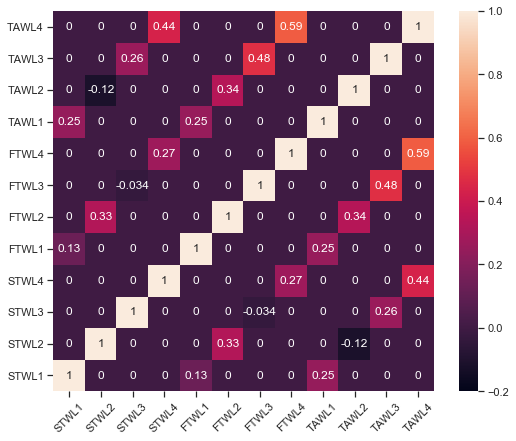

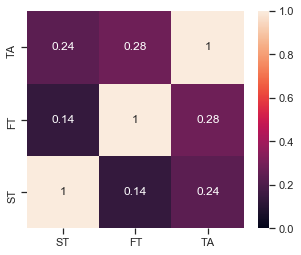

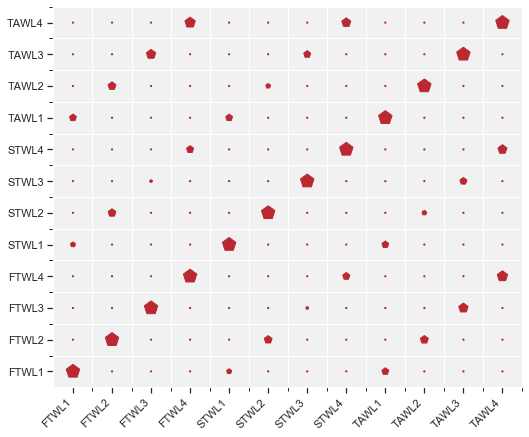

In [20]:
path_to_comparisons = r'C:\Users\Denis Logvinenko\Desktop\Projekt\Word Lists\ru\Tests - Comparison'

data_labels_short = ['ST', 'FT', 'TA']
data_labels_long = [f'{label}WL{idx}' for label in data_labels_short for idx in range(1,5)]

heatmap_classic(path_to_jsons=path_to_comparisons, data_labels=data_labels_long, vmin=-0.2, full=True)
heatmap_classic(path_to_jsons=path_to_comparisons, data_labels=data_labels_short, vmin=0, full=False)
heatmap_markers(path_to_jsons=path_to_comparisons, data_labels=data_labels_long, full=True, marker='p')